# Useful pieces for Tandem simulation
Last modification: 2023.06.23. </br>
Update note: Introduce make_uniform

# Initiate

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
from cmcrameri import cm
import myplots
import change_params
import setup_shortcut

sc = setup_shortcut.setups()
ch = change_params.variate()
mp = myplots.Figpref()

prefix = 'BP1_test_deltasn/delsn5'

save_dir = '/export/dump/jyun/'+prefix
plot_dir = '%s'%(prefix.split('/')[-1])
y,Hs,a,b,a_b,tau0,sigma0,Dc,others = ch.load_parameter(prefix)

print('prefix =',prefix)
print('len(y):',len(y))
print('len(a_b):',len(a_b))
print('len(tau0):',len(tau0))
print('len(sigma0):',len(sigma0))
print('len(Dc):',len(Dc))
print('others[-1]:',others[-1])

No parameters changed - returning regular output
prefix = BP1_test_deltasn/delsn4
len(y): 1000
len(a_b): 1000
len(tau0): 1000
len(sigma0): 1000
len(Dc): 1000
others[-1]: 0.6


# Time conversion

## Seconds to hours, minutes, and seconds

In [ ]:
sc.sec2hms(32063)

## Seconds to years, years to seconds

In [ ]:
# # Second to years
# sec = 22075200000
sec = 5.196384621807955e9
'%2.2f yrs'%(sec/sc.yr2sec)

# Years to seconds
# years = 1200
# '%d s'%(years*sc.yr2sec)

# Print out receiver location

In [ ]:
dip = np.deg2rad(30)
d = 0
c = 0
fid = open('dp.txt','w')
while d <= 100:
    if d < 60:
        dt = 0.5
    else:
        dt = 5
    x = -d/np.tan(np.pi-dip)
    fid.write('{ name = "dp%03d", x = [%1.4f, %1.4f] },\n'%(c,x,-d))
    d += dt
    c += 1
fid.close()

In [ ]:
fid = open('dp.txt','r')
lines = fid.readlines()
xx,yy = [],[]
for line in lines:
    x = line.split('[')[-1]
    xx.append(float(x.split(',')[0]))
    y = line.split(']')[0]
    yy.append(float(y.split(',')[-1]))
            
fid.close()

plt.plot(xx,yy)

In [ ]:
dip_rad = 30 * np.pi / 180.0
dX = 400
S = 200
X0 = -dX
X1 = S * np.cos(dip_rad) / np.sin(dip_rad) + dX
print(X0,X1)

# Check things

## Initial stress

In [ ]:
save_on = 1

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(9,7))
y,Hs,a,b,_a_b,tau0,_sigma0,L,others = ch.load_parameter(prefix)
if len(_sigma0) == 2:
    sigma0 = _sigma0[0]
    y_in = _sigma0[1]
    tau0 = ch.same_length(y,tau0,y_in)
else:
    sigma0 = _sigma0
    y_in = y

def read_output(fname):
    fid = open(fname,'r')
    lines = fid.readlines()
    mesh_y = []
    sigma = []
    tau = []
    c = 0
    for line in lines:
        try:
            _x, _y, _sn, _tau = line.split('\t')
        except:
            print('skip line %d:'%(c),line.strip())
            continue
        try:
            mesh_y.append(float(_y.strip())); sigma.append(float(_sn.strip())); tau.append(float(_tau.strip()))
        except:
            print('skip line %d:'%(c),line.strip())
            continue
        c += 1
    print('Total %d points'%c)
    fid.close()
    idx = np.argsort(np.array(mesh_y))
    mesh_y = np.array(mesh_y)[idx]; sigma = np.array(sigma)[idx]; tau = np.array(tau)[idx]
    return mesh_y,sigma,tau

mesh_y,sigma,tau = read_output('mtmod_team3/stress_profile_%s'%(prefix.split('/')[-1]))

ax.plot(sigma0,abs(y_in),lw=3,color=mp.mypink,label='Input Normal Stress')
ax.plot(tau0,abs(y_in),lw=3,color='0.62',label='Input Shear Stress')
ax.scatter(sigma,abs(mesh_y),lw=3,color=mp.myburgundy,label='Output Normal Stress',zorder=3)
ax.scatter(tau,abs(mesh_y),lw=3,color='k',label='Output Shear Stress',zorder=3)
ax.set_xlabel('Stress [MPa]',fontsize=17)
ax.set_ylabel('Depth [km]',fontsize=17)
ax.set_ylim(0,Hs[0])
ax.invert_yaxis()
plt.grid(True)
ax.legend(fontsize=13,loc='lower right')
plt.tight_layout()
if save_on:
    plt.savefig('%s/%s_stress_profile.png'%(prefix.split('/')[0],prefix.split('/')[-1]))

In [ ]:
Vp = 1e-9
V0 = 1e-6
dip = np.deg2rad(30)
# print(np.log(Vp/np.cos(dip)/V0))
print(-50*0.6)
print(-(50*0.6 + np.log(Vp/np.cos(dip)/V0)))

## a-b profile

In [ ]:
save_on = 0

y,Hs,a0,b0,_a_b = ch.load_parameter(prefix)[0:5]
if len(_a_b) == 2:
    y_in = _a_b[1]
else:
    y_in = y
    
def read_output(fname):
    fid = open(fname,'r')
    lines = fid.readlines()
    mesh_y = []
    a = []
    b = []
    c = 0
    for line in lines:
        try:
            _x,_y, _a, _b = line.split('\t')
        except:
            print('skip line %d:'%(c),line.strip())
            continue
        try:
            mesh_y.append(float(_y.strip())); a.append(float(_a.strip())); b.append(float(_b.strip()))
        except:
            print('skip line %d:'%(c),line.strip())
            continue
        c += 1
    print('Total %d points'%c)
    fid.close()
    idx = np.argsort(np.array(mesh_y))
    mesh_y = np.array(mesh_y)[idx]; a = np.array(a)[idx]; b = np.array(b)[idx]
    return mesh_y,a,b        

mesh_y,a,b = read_output('mtmod_team3/ab_profile_%s'%(prefix.split('/')[-1]))

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(9,7))
ax.plot(b0,abs(y_in),color='0.62',lw=3,label='Input b',zorder=3)
ax.plot(a0-b0,abs(y_in),color=mp.mypink,lw=3,label='Input a-b',zorder=3)
ax.scatter(b,abs(mesh_y),color='k',lw=3,label='Output b',zorder=3)
ax.scatter(a-b,abs(mesh_y),color=mp.myburgundy,lw=3,label='Output a-b',zorder=3)
ax.set_xlabel('Friction Paramters',fontsize=17)
ax.set_ylabel('Depth [km]',fontsize=17)
xl = ax.get_xlim()
ax.set_ylim(0,Hs[0])
ax.vlines(x=0.,ymin=0,ymax=Hs[0],lw=2.5,linestyles='--',color='0.62')
# ax.hlines(y=Hs[2],xmin=xl[0],xmax=xl[1],lw=1.5,linestyles='--',color='0.62')
# ax.hlines(y=Hs[1],xmin=xl[0],xmax=xl[1],lw=1.5,linestyles='--',color='0.62')
ax.set_xlim(xl)
ax.invert_yaxis()
plt.grid(True)
ax.legend(fontsize=13,loc='lower left')
plt.tight_layout()
if save_on:
    plt.savefig('%s/%s_ab_profile.png'%(prefix.split('/')[0],prefix.split('/')[-1]))

## Dc

In [ ]:
save_on = 0

if len(Dc) == 2:
    y_in = Dc[1]
else:
    y_in = y

def read_output(fname):
    fid = open(fname,'r')
    lines = fid.readlines()
    mesh_y = []
    a = []
    b = []
    c = 0
    for line in lines:
        try:
            _x,_y, _a = line.split('\t')
        except:
            print('skip line %d:'%(c),line.strip())
            continue
        try:
            mesh_y.append(float(_y.strip())); a.append(float(_a.strip())); 
        except:
            print('skip line %d:'%(c),line.strip())
            continue
        c += 1
    print('Total %d points'%c)
    fid.close()
    idx = np.argsort(np.array(mesh_y))
    mesh_y = np.array(mesh_y)[idx]; a = np.array(a)[idx]
    return mesh_y,a

mesh_y,Dc_out = read_output('mtmod_team3/dc_profile_%s'%(prefix.split('/')[-1]))

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(9,7))
ax.plot(Dc,abs(y_in),color=mp.mypink,lw=3,zorder=3)
ax.scatter(Dc_out,abs(mesh_y),color=mp.myburgundy,lw=3,zorder=3)
ax.set_xlabel('Dc [m]',fontsize=17)
ax.set_ylabel('Depth [km]',fontsize=17)
xl = ax.get_xlim()
ax.set_ylim(0,Hs[0])
# ax.vlines(x=0.,ymin=0,ymax=Hs[0],lw=2.5,linestyles='--',color='0.62')
# ax.hlines(y=Hs[2],xmin=xl[0],xmax=xl[1],lw=1.5,linestyles='--',color='0.62')
# ax.hlines(y=Hs[1],xmin=xl[0],xmax=xl[1],lw=1.5,linestyles='--',color='0.62')
ax.set_xlim(xl)
ax.invert_yaxis()
plt.grid(True)
plt.tight_layout()
if save_on:
    plt.savefig('%s/%s_dc_profile.png'%(prefix.split('/')[0],prefix.split('/')[-1]))

## Mu

In [ ]:
save_on = 0

def read_output(fname):
    fid = open(fname,'r')
    lines = fid.readlines()
    mesh_x = []
    mesh_y = []
    a = []
    c = 0
    for line in lines:
        try:
            _x, _y, _a = line.split('\t')
        except:
            print('skip line %d:'%(c),line.strip())
            continue
        try:
            mesh_x.append(float(_x.strip())); 
            mesh_y.append(float(_y.strip())); 
            a.append(float(_a.strip())); 
        except:
            print('skip line %d:'%(c),line.strip())
            continue
        c += 1
    print('Total %d points'%c)
    fid.close()
    idx = np.argsort(np.array(mesh_y))
    mesh_x = np.array(mesh_x)[idx]; mesh_y = np.array(mesh_y)[idx]; a = np.array(a)[idx]
    return mesh_x,mesh_y,a

mesh_x,mesh_y,mu_out = read_output('mtmod_team3/mu_profile_%s'%(prefix.split('/')[-1]))

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(9,7))
# ax.scatter(mesh_x,mesh_y,c=mu_out,cmap='seismic_r')
# ax.plot(others[-1],abs(y),color=mp.mypink,lw=3,zorder=3,label='Input μ')
ax.scatter(mu_out,abs(mesh_y),color=mp.myburgundy,lw=3,zorder=3,label='Output μ')
ax.set_xlabel('Shear Modulus [MPa]',fontsize=17)
ax.set_ylabel('Depth [km]',fontsize=17)
ax.legend(loc='lower left',fontsize=13)
xl = ax.get_xlim()
ax.set_ylim(0,Hs[0])
# ax.vlines(x=0.,ymin=0,ymax=Hs[0],lw=2.5,linestyles='--',color='0.62')
# ax.hlines(y=Hs[2],xmin=xl[0],xmax=xl[1],lw=1.5,linestyles='--',color='0.62')
# ax.hlines(y=Hs[1],xmin=xl[0],xmax=xl[1],lw=1.5,linestyles='--',color='0.62')
ax.set_xlim(xl)
ax.invert_yaxis()
plt.grid(True)
plt.tight_layout()
if save_on:
    plt.savefig('%s/%s_mu_profile.png'%(prefix.split('/')[0],prefix.split('/')[-1]))

## Delta_sn

Total 1026830 points


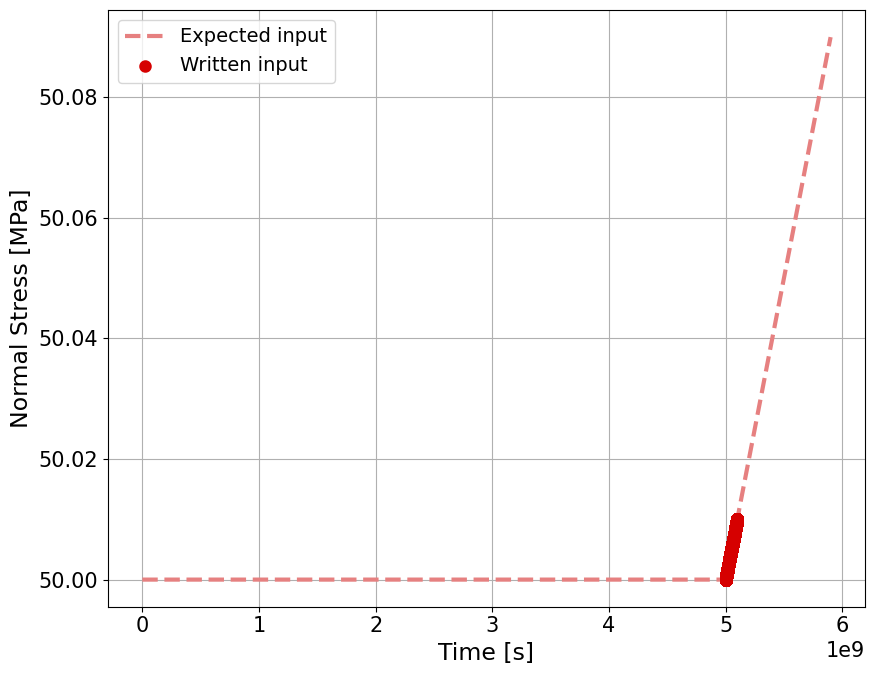

In [9]:
save_on = 0

def read_output(fname):
    fid = open(fname,'r')
    lines = fid.readlines()
    mesh_y = []
    a = []
    b = []
    c = 0
    for line in lines:
        try:
            _y, _a = line.split('\t')
        except:
            print('skip line %d:'%(c),line.strip())
            continue
        try:
            mesh_y.append(float(_y.strip())); a.append(float(_a.strip())); 
        except:
            print('skip line %d:'%(c),line.strip())
            continue
        c += 1
    print('Total %d points'%c)
    fid.close()
    idx = np.argsort(np.array(mesh_y))
    mesh_y = np.array(mesh_y)[idx]; a = np.array(a)[idx]
    return mesh_y,a

time = np.linspace(0,5.9,1000)
_del_sn = np.zeros(time.shape)
for k,t in enumerate(time):
    if t > 10:
        _del_sn[k] = -(t-10)*1.0/15+0.5
    elif t > 5:
        _del_sn[k] = (t-5)*0.5/5
    else:
        _del_sn[k] = 0.0

time_out,delsn_out = read_output('BP1_test_deltasn/deltasn_profile_deltasn%s'%(prefix.split('/')[-1][-1]))

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(9,7))
ax.plot(time*1e9,_del_sn+50,color=mp.mypink,lw=3,zorder=3,linestyle='--',label='Expected input')
ax.scatter(time_out,delsn_out+50,color=mp.myburgundy,lw=3,zorder=3,label='Written input')
ax.legend(fontsize=14,loc='upper left')
ax.set_xlabel('Time [s]',fontsize=17)
ax.set_ylabel('Normal Stress [MPa]',fontsize=17)
plt.grid(True)
plt.tight_layout()
if save_on:
    plt.savefig('%s/%s_dc_profile.png'%(prefix.split('/')[0],prefix.split('/')[-1]))

In [5]:
delsn_out

array([4.89463913e-06, 4.89463913e-06, 4.89463913e-06, ...,
       7.73861274e-03, 7.73861274e-03, 7.73861274e-03])

# a/b vs. Ru

In [ ]:
save_on = 1
# --------- Interpolate variables to match the lengths: b, sigma & a-b
mesh_y,_a,_b,_ab,_sigma,_Dc = ch.make_uniform(prefix)

# Shear modulus (within DZ for DZ model)
mu = 15e9

# --------- Mask out only VW zone
# VW = np.where(np.logical_and(-mesh_y >= Hs[-1], -mesh_y<= Hs[1]))[0]
VW = np.where(_ab<0)[0]
L = abs(mesh_y[VW[-1]] - mesh_y[VW[0]])*1e3
print('L = %2.3f km'%(L/1e3))
aa = _a[VW]; bb = _b[VW]; mesh_y = mesh_y[VW]; sigma_n = _sigma[VW]*1e6; D_c = _Dc[VW]

# --------- Compute a/b and Ru number
# D_c = 0.0008*np.ones(len(D_c))
if not 'DZ' in prefix:
    if max(D_c)-min(D_c) > 1e-4:
        print('Mu = %dGPa, Dc = %1.4f - %1.4f m'%(mu/1e9,min(D_c),max(D_c)))
    else:
        print('Mu = %dGPa, Dc = %2.3f m'%(mu/1e9,min(Dc)))
LnRR = mu*D_c/(sigma_n*(bb-aa))
Ru = L/LnRR
# if 'DZ' in prefix:
#     print('Damage zone model')
#     G = 32          # domain shear modulus in GPa
#     Gcz = mu/1e9    # DZ shear modulus in GPa
#     T = 0.5         # DZ width in km
#     W = L/1e3       # seismogenic zone width in km
#     print('G = %d GPa, Gcz = %d GPa, T = %2.2f km, W = %2.2f km'%(G,Gcz,T,W))
#     incoth = np.pi*Ru*T/W + np.arctanh(Gcz/G)
#     Geff = Gcz / np.tanh(incoth)
#     Ru = W*(bb-aa)*sigma_n/L/Geff

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(ncols=2,figsize=(7,7))

ax[0].plot(Ru,-mesh_y,color='k',lw=3,label='a/b',zorder=3)
print('Ru = %2.3f - %2.3f'%(min(Ru),max(Ru)))
ax[0].set_xlabel('Ru',fontsize=17)
ax[0].set_ylabel('Depth [km]',fontsize=17)
xl = ax[0].get_xlim()
ax[0].set_xlim(0,xl[1])
# ax[0].set_xlim(0,500)
ax[0].set_ylim(0,24)
ax[0].invert_yaxis()
ax[0].grid(True)
if max(D_c)-min(D_c) > 1e-4:
    ax[0].text(xl[1]*0.1,23,'Mu = %dGPa\nDc: fractal\nMin. %2.3f\nMax. %2.3f'%(mu/1e9,min(Ru),max(Ru)),fontsize=16,va='bottom',ha='left',bbox=mp.tboxprop)
else:
    ax[0].text(xl[1]*0.1,23,'Mu = %dGPa\nDc = %2.4f m\nMin. %2.3f\nMax. %2.3f'%(mu/1e9,min(D_c),min(Ru),max(Ru)),fontsize=16,va='bottom',ha='left',bbox=mp.tboxprop)

ax[1].plot(aa/bb,-mesh_y,color='k',lw=3,label='Ru',zorder=3)
print('a/b = %2.3f - %2.3f'%(min(aa/bb),max(aa/bb)))
ax[1].set_xlabel('a/b',fontsize=17)
# ax[1].set_ylabel('Depth [km]',fontsize=17)
ax[1].axes.yaxis.set_ticklabels([])
xl = ax[1].get_xlim()
ax[1].set_xlim(xl[0],1.)
ax[1].set_ylim(0,24)
ax[1].invert_yaxis()
ax[1].grid(True)
if max(D_c)-min(D_c) > 1e-4:
    ax[1].text(xl[0]+(1-xl[0])*0.1,23,'Mu = %dGPa\nDc: fractal\nMin. %2.3f\nMax. %2.3f'%(mu/1e9,min(aa/bb),max(aa/bb)),fontsize=16,va='bottom',ha='left',bbox=mp.tboxprop)
else:
    ax[1].text(xl[0]+(1-xl[0])*0.1,23,'Mu = %dGPa\nDc = %2.4f m\nMin. %2.3f\nMax. %2.3f'%(mu/1e9,min(D_c),min(aa/bb),max(aa/bb)),fontsize=16,va='bottom',ha='left',bbox=mp.tboxprop)

plt.tight_layout()

if save_on:
    if max(D_c)-min(D_c) > 1e-4:
        # if 'DZ' in prefix:
        #     plt.savefig('%s/abRu_%d_NnB22.png'%(prefix,mu/1e9))
        # else:
        #     plt.savefig('%s/abRu_%d.png'%(prefix,mu/1e9))
        plt.savefig('%s/abRu_%d.png'%(prefix,mu/1e9))
    else:
        # if 'DZ' in prefix:
        #     plt.savefig('%s/abRu_%d_%d_NnB22.png'%(prefix,mu/1e9,min(D_c)*1e4))
        # else:
        #     plt.savefig('%s/abRu_%d_%d.png'%(prefix,mu/1e9,min(D_c)*1e4))
        plt.savefig('%s/abRu_%d_%d.png'%(prefix,mu/1e9,min(D_c)*1e4))

plt.show()

In [ ]:
others[-1][0]

# Mesh resolution

In [ ]:
# --------- Interpolate variables to match the lengths: b, sigma & a-b
mesh_y,_a,_b,_ab,_sigma,_Dc = ch.make_uniform(prefix) 


from scipy import interpolate
f_var = interpolate.interp1d(y,others[-1],bounds_error=False,fill_value=others[-1][0])
_mu = f_var(mesh_y)


# ------------------ Input
# mu = 32e9               # Shear modulus [Pa]
# _Dc = 2e-3*np.ones(len(_Dc))
C = 1                   # Constant of order 1
# muprime = mu            # For anti-plane

# idx = np.where(np.logical_and(-mesh_y >= Hs[-1], -mesh_y<= Hs[1]))[0]
# idx = np.where(_ab<0)[0]
idx = np.where(abs(mesh_y)<=10)[0]
_a_b = _ab[idx]
b0 = _b[idx]
D_c = _Dc[idx]
sigma_n = _sigma[idx]*1e6                             # Effective normal stress [Pa]
mu = _mu[idx]
muprime = mu            # For anti-plane

# ------------------ Input
lambda0 = C*mu*D_c/b0/sigma_n                          # Process zone / cohesive zone
hstar = np.pi*mu*b0*D_c/(2*sigma_n*(_a_b**2))          # Nucleation size for 0.5 < a/b < 1, aging law; Chen & Lapusta (2009)
Linf = b0*muprime*D_c/(np.pi*sigma_n*_a_b**2)          # Rubin and Ampuero (2005)

# ------- Tandem build related info.
polyd = 6
numcell = 6

if max(b0)-min(b0) > 1e-3 and max(D_c)-min(D_c) > 1e-4:
    print('C =',C,', mu =',mu/1e9,'GPa, b =',min(b0),'-',max(b0),'Dc = %1.4f - %1.4f m'%(min(D_c),max(D_c)))
elif max(b0)-min(b0) > 1e-3:
    print('C =',C,', mu =',mu/1e9,'GPa, b =',min(b0),'-',max(b0),'Dc =',min(D_c))
elif max(D_c)-min(D_c) > 1e-4:
    print('C =',C,', mu =',mu/1e9,'GPa, b =',min(b0),'Dc = %1.4f - %1.4f m'%(min(D_c),max(D_c)))
else:
    print('C =',C,', mu =',mu/1e9,'GPa, b =',min(b0),'Dc =',min(D_c))
print('Min. process zone size: %2.2f m'%(min(lambda0)))
print('Min. nucleation size: %2.2f m'%(min(hstar)))
print('Max. element size to sample critical length by %d cells: %2.2f m'%(int(numcell),polyd*min(min(lambda0),min(hstar))/numcell))

print(min(lambda0)/1e3,min(hstar)/1e3,min(Linf)/1e3)

In [ ]:
# --------- Interpolate variables to match the lengths: b, sigma & a-b
mesh_y,_a,_b,_ab,_sigma,_Dc = ch.make_uniform(prefix) 


from scipy import interpolate
f_var = interpolate.interp1d(y,others[-1],bounds_error=False,fill_value=others[-1][0])
_mu = f_var(mesh_y)


# ------------------ Input
# mu = 32e9               # Shear modulus [Pa]
# _Dc = 2e-3*np.ones(len(_Dc))
C = 1                   # Constant of order 1
# muprime = mu            # For anti-plane

# idx = np.where(np.logical_and(-mesh_y >= Hs[-1], -mesh_y<= Hs[1]))[0]
# idx = np.where(_ab<0)[0]
idx = np.where(abs(mesh_y)<=10)[0]
_a_b = _ab[idx]
b0 = _b[idx]
D_c = _Dc[idx]
sigma_n = _sigma[idx]*1e6                             # Effective normal stress [Pa]
mu = _mu[idx]
muprime = mu            # For anti-plane

# ------------------ Input
lambda0 = C*mu*D_c/b0/sigma_n                          # Process zone / cohesive zone
hstar = np.pi*mu*b0*D_c/(2*sigma_n*(_a_b**2))          # Nucleation size for 0.5 < a/b < 1, aging law; Chen & Lapusta (2009)
Linf = b0*muprime*D_c/(np.pi*sigma_n*_a_b**2)          # Rubin and Ampuero (2005)

crit_lengths = np.vstack((lambda0,hstar,Linf))

# ------- Tandem build related info.
polyd = 6
numcell = 6

if max(b0)-min(b0) > 1e-3 and max(D_c)-min(D_c) > 1e-4:
    print('C =',C,', mu =',mu/1e9,'GPa, b =',min(b0),'-',max(b0),'Dc = %1.4f - %1.4f m'%(min(D_c),max(D_c)))
elif max(b0)-min(b0) > 1e-3:
    print('C =',C,', mu =',mu/1e9,'GPa, b =',min(b0),'-',max(b0),'Dc =',min(D_c))
elif max(D_c)-min(D_c) > 1e-4:
    print('C =',C,', mu =',mu/1e9,'GPa, b =',min(b0),'Dc = %1.4f - %1.4f m'%(min(D_c),max(D_c)))
else:
    print('C =',C,', mu =',mu/1e9,'GPa, b =',min(b0),'Dc =',min(D_c))

print('Min. process zone size: %2.2f m'%(min(lambda0)))
print('Min. nucleation size: %2.2f m'%(min(hstar)))
print('Max. element size to sample critical length by %d cells: %2.2f m'%(int(numcell),polyd*min(min(lambda0),min(hstar))/numcell))

W = 10
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(6,8))
# plt.plot(polyd*np.min(crit_lengths,axis=0)/numcell,mesh_y[idx],'k',lw=2.5)
# plt.plot(polyd*np.min(crit_lengths,axis=0)/numcell,-mesh_y[idx],'k',lw=2.5)
plt.plot(W/Linf,-mesh_y[idx],'k',lw=2.5)
# plt.plot(_a_b,-mesh_y[idx],'k',lw=2.5)
# plt.plot(_a_b,-mesh_y,'k',lw=2.5)
plt.xlabel('W/Linf',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('W_Lf_patchmu.png')
plt.show()

# MPI rank vs. load time

In [ ]:
save_on = 1

# mpirank = np.array([1,2,4,8,16,32,64])
mpirank = np.array([0,1,2,3,4,5,6])
loadtime_m = [32.37,16.87,13.12,10.55,9.66,8.94,300]
loadtime_ca = [33.31,21.58,12.30,10.59,8.59,9.60,300]
loadtime_rt = [15.30,10.95,7.79,7.01,5.74,300,300]

wd = 0.2
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(10,8))
plt.bar(mpirank-wd*1.5,loadtime_m,width=wd, color=mp.myblue,edgecolor='k',align='edge',label='Master')
plt.bar(mpirank-wd/2,loadtime_ca,width=wd, color=mp.mypalepink,edgecolor='k',align='edge',label='Casper\'s (manual)')
plt.bar(mpirank+wd*0.5,loadtime_rt,width=wd, color=mp.mygreen,edgecolor='k',align='edge',label='Casper\'s (region tag)')
plt.ylim(0,40)
# plt.xscale('log', base=2)
plt.xticks(ticks=mpirank,labels=['1','2','4','8','16','32','64'])
plt.xlabel('MPI Rank',fontsize=17)
plt.ylabel('Time [s]',fontsize=17)
plt.title('Mesh with 14,912 elements',fontsize=20,fontweight='bold')
plt.legend(fontsize=13,loc='upper left')
plt.tight_layout()
if save_on:
    plt.savefig('MPIrank_vs_time.png')
plt.show()

# Various critical lengths

In [ ]:
# --------- Interpolate variables to match the lengths
f_ab = interpolate.interp1d(y,a_b,bounds_error=False,fill_value=a_b[0])
f_a = interpolate.interp1d(y,a,bounds_error=False,fill_value=a[0])
f_b = interpolate.interp1d(y,b,bounds_error=False,fill_value=b[0])

_ab = f_ab(mesh_y)
_b = f_b(mesh_y)

# ------------------ Input
mu = 10e9               # Shear modulus [Pa]
Dc = 0.004              # Characteristic distance [m]
C = 1                   # Constant of order 1
muprime = mu            # For anti-plane

idx = np.where(np.logical_and(-mesh_y >= Hs[-1], -mesh_y<= Hs[1]))[0]
_a_b = _ab[idx]
b0 = _b[idx]
sigma_n = sigma0[idx]*1e6                                    # Effective normal stress [Pa]

# ------------------ Input
lambda0 = C*mu*Dc/b0/sigma_n                          # Process zone / cohesive zone
hstar = np.pi*mu*b0*Dc/(2*sigma_n*(_a_b**2))          # Nucleation size for 0.5 < a/b < 1, aging law; Chen & Lapusta (2009)
Linf = b0*muprime*Dc/(np.pi*sigma_n*(_a_b**2))        # Rubin and Ampuero (2005)

print('Process zone size      : %2.2f m - %2.2f m'%(min(lambda0),max(lambda0)))
print('Nucleation size (hstar; CnL09): %2.2f m - %2.2f m'%(min(hstar),max(hstar)))
print('Nucleation size (Linf; RnA09): %2.2f m - %2.2f m'%(min(Linf),max(Linf)))
print('Minimum critical lengths: %2.2f m'%(min(min(lambda0),min(hstar),min(Linf))))


# Domain probe output

In [ ]:
from glob import glob
from csv import reader

def read_fault_probe_outputs(save_dir,save_on=True):
    fnames = glob('%s/domain_probe_*.csv'%(save_dir))
    if len(fnames) == 0:
        print(fnames)
        raise NameError('No such file found - check the input')
    outputs = ()
    pos = []
    for fn in fnames:
        with open(fn, 'r') as csvfile:
            csvreader = reader(csvfile)
            stloc = next(csvreader)
            rx = float(stloc[0].split('[')[1].split(',')[0])
            rz = float(stloc[1].split(']')[0])
            pos.append([rx,rz])
            next(csvreader)
            dat = []
            for row in csvreader:
                dat.append(np.asarray(row).astype(float))
        outputs = outputs + (dat,)
    outputs = np.array(outputs)
    pos = np.array(pos)
    if save_on:
        print('Save data...',end=' ')
        np.save('%s/domain_probe_outputs'%(save_dir),outputs)
        np.save('%s/domain_probe_outputs_position'%(save_dir),pos)
        print('done!')
    return outputs,pos

In [ ]:
outputs,pos = read_fault_probe_outputs('/export/dump/jyun/%s/outputs_%s'%(prefix.split('/')[0],prefix.split('/')[1]),save_on=True)
print(outputs.shape)
time = np.array([outputs[i,:,0] for i in range(outputs.shape[0])])
u0 = np.array([outputs[i,:,1] for i in range(outputs.shape[0])])
u1 = np.array([outputs[i,:,2] for i in range(outputs.shape[0])])

In [ ]:
pi = 5
print(pos[pi])

plt.figure(figsize=(8,6))
plt.plot(time[pi],u0[pi],lw=3,c='k')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
# plt.plot(time,u1)
plt.show()

In [ ]:
print(np.where(u0 > 1e-3)[0])
print(np.where(u1 > 1e-3)[0])